In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='arial') 
from h5py import File
from fish.image.zds import ZDS
from matplotlib import cm
from skimage.exposure import rescale_intensity as rescale
import flika as flk
flk.start_flika()
from moviepy.editor import VideoClip,concatenate_videoclips
from moviepy.video.io.bindings import mplfig_to_npimage
from flika.window import Window as flw
from matplotlib.patches import Rectangle as Rect
%matplotlib inline

Starting flika
Starting flika inside IPython


In [2]:
base_dirs  = ( '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimagingGlia/20181227/fish1/20181227_1_3_gfaprgeco_gfapcochr_7dpf_stimwaist_20181227_130537/',
                '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimagingGlia/20181227/fish1/20181227_1_4_gfaprgeco_gfapcochr_7dpf_stimwaist_20181227_133336/',
                '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimagingGlia/20181227/fish2/20181227_2_2_gfaprgeco_gfapcochr_7dpf_stimwaist_20181227_145406/',
                '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimagingGlia/20181227/fish3/20181227_3_2_gfaprgeco_gfapcochr_7dpf_stimwaist_20181227_155902/',
                '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimagingGlia/20181227/fish4/20181227_4_2_gfaprgeco_gfapcochr_7dpf_stimwaist_20181227_171436/',
                '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimagingGlia/20181227/fish4/20181227_4_3_gfaprgeco_gfapcochr_7dpf_stimwaist_20181227_175325/',
                '/nrs/ahrens/Yu/SPIM/active_dataset/stimGliaimagingGlia/20181227/fish5/20181227_5_2_gfaprgeco_gfapcochr_7dpf_stimwaist_20181227_184139/',)

In [3]:
from scipy.ndimage import rotate
from os.path import sep
exp = 4
dset = ZDS(base_dirs[exp] + '/raw/')
tmp_dir = f'/nrs/ahrens/davis/tmp/{base_dirs[exp].split(sep)[-2]}/'
trave_file = glob(tmp_dir + '*trave*.h5')[0]
fs_im = dset.metadata['volume_rate']
angles = [-5,-5,-5,-5,-5,-5,-5]
trials = File(trave_file)['condition_0/trave'][:]
trave = trials.mean(0)
trave = rotate(trave, angle=angles[exp], axes=(-2,-1), cval=np.percentile(trave.ravel(), 20))
window = File(trave_file)['condition_0/window'][:]

thr = 1.5
ons = trave.shape[0] - (np.where(trave.max((1,2,3))[::-1] > thr)[0][0])
stim_epoch = [(np.where(trave.max((1,2,3)) > thr)[0][0])-2, ons-2]

In [4]:
from skimage.io import imread
full = imread(glob(tmp_dir + '*_dff_ds2*.tif')[-1]).max(1)

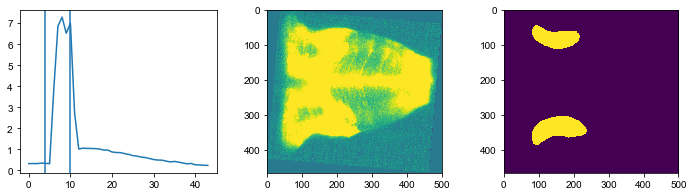

In [5]:
from scipy.ndimage.morphology import binary_dilation, binary_opening
from skimage.morphology import disk
from shapely.geometry import asMultiPoint

stim_mask = trave[ons-2].max(0) > 1.5
stim_mask_morphed = binary_opening(stim_mask, disk(3))
mulp = asMultiPoint(list(zip(*np.where(stim_mask_morphed)[::-1])))
pol = mulp.buffer(0.5,cap_style=3, join_style=1)
roi_boundaries = [p.exterior.xy for p in pol]

fig, axs = plt.subplots(ncols=3, figsize=(12,3))
axs[0].plot(trave.max((1,2,3,)))
axs[0].axvline(stim_epoch[0])
axs[0].axvline(stim_epoch[-1])

axs[1].imshow(trave[ons:].mean((0,1)), clim=(0,.05))
axs[2].imshow(stim_mask_morphed)

In [6]:
from scipy.ndimage.filters import gaussian_filter1d
dur = int(trave.shape[0] / 4)
plr_stim = slice(ons, ons+dur), slice(20,400), slice(30,280)

def get_phase(data):
    return np.argmax(np.diff(gaussian_filter1d(data,axis=0, sigma=1.5),axis=0).clip(0, None), axis=0)

phase = get_phase(trave.max(1)[plr_stim])

anat = trave[:5].mean(0).max(0)[plr_stim[1:]]
mag = trave[ons:].max(0).max(0)[plr_stim[1:]]
mask = mag > 0
mask_rgb = np.array(4*[mask]).transpose(1,2,0)
anat_rgb = cm.gray(rescale(anat, out_range=(0,1)))
phase_rgb = cm.rainbow(rescale(phase.astype('float32'), out_range=(0,1))) * mask_rgb
mag_rgb = cm.gray(rescale(mag, out_range=(0,1)))

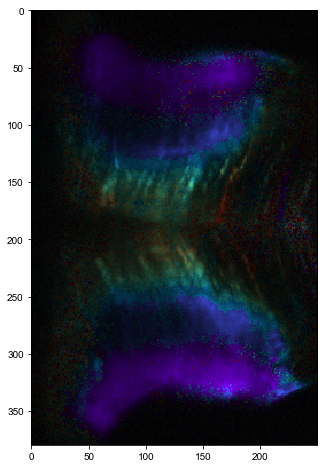

In [7]:
fig, axs = plt.subplots(figsize=(8,8))
plt.imshow(phase_rgb * mag_rgb)

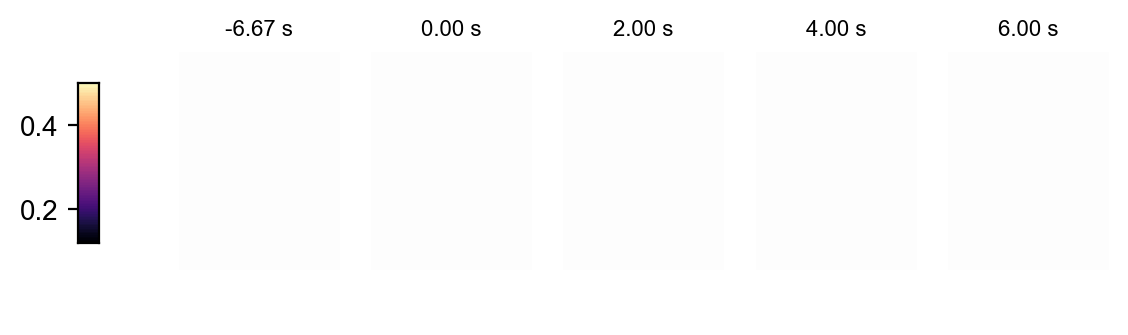

In [8]:
# Show a sequence of frames
from fish.util.plot import apply_cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable

t_points = [0,10,13,16,19]
t_stim = 10
plr = slice(None), slice(10,-50), slice(0,300)

anat = apply_cmap(trave.max(1)[plr][0], 'gray')

fig, axs = plt.subplots(dpi=200, figsize=(6, 4), ncols=len(t_points))
[ax.axis('off') for ax in axs.ravel()]
dff_clim=(.12, .5)
for ind, t in enumerate(t_points):
    dff = apply_cmap(trave.max(1)[plr][t].clip(*dff_clim), 'magma')
    axs[ind].imshow((anat.astype('float') + dff.astype('float')).clip(0,255).astype('uint8'))
    axs[ind].title.set_text(f'{(t - t_stim) / fs_im:.2f} s')
    axs[ind].title.set_fontsize(8)

axs_cmap = fig.add_axes((0,.4,.1,.2))
axs_cmap.imshow(np.array([np.linspace(dff_clim[0], dff_clim[-1], 100)] * 10).T, origin='lower', cmap='magma', extent=(0,.05,.12,.5))
axs_cmap.set_xticks([])
plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/gfap_stim_sequence.pdf')

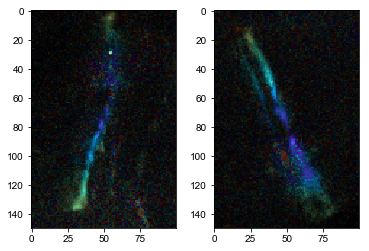

In [9]:
plr_examples = ((slice(298, 298 + dur), slice(50,200), slice(170,270)),
               (slice(661, 661 + dur), slice(170, 320), slice(235, 335)))

phase_examples = [cm.rainbow(rescale(get_phase(full[plr]).astype('float'))) for plr in plr_examples]
mag_examples = [cm.gray(rescale(full[plr].max(0))) for plr in plr_examples]

fig, axs = plt.subplots(ncols=2)
axs[0].imshow(phase_examples[0] * mag_examples[0])
axs[1].imshow(phase_examples[1] * mag_examples[1])

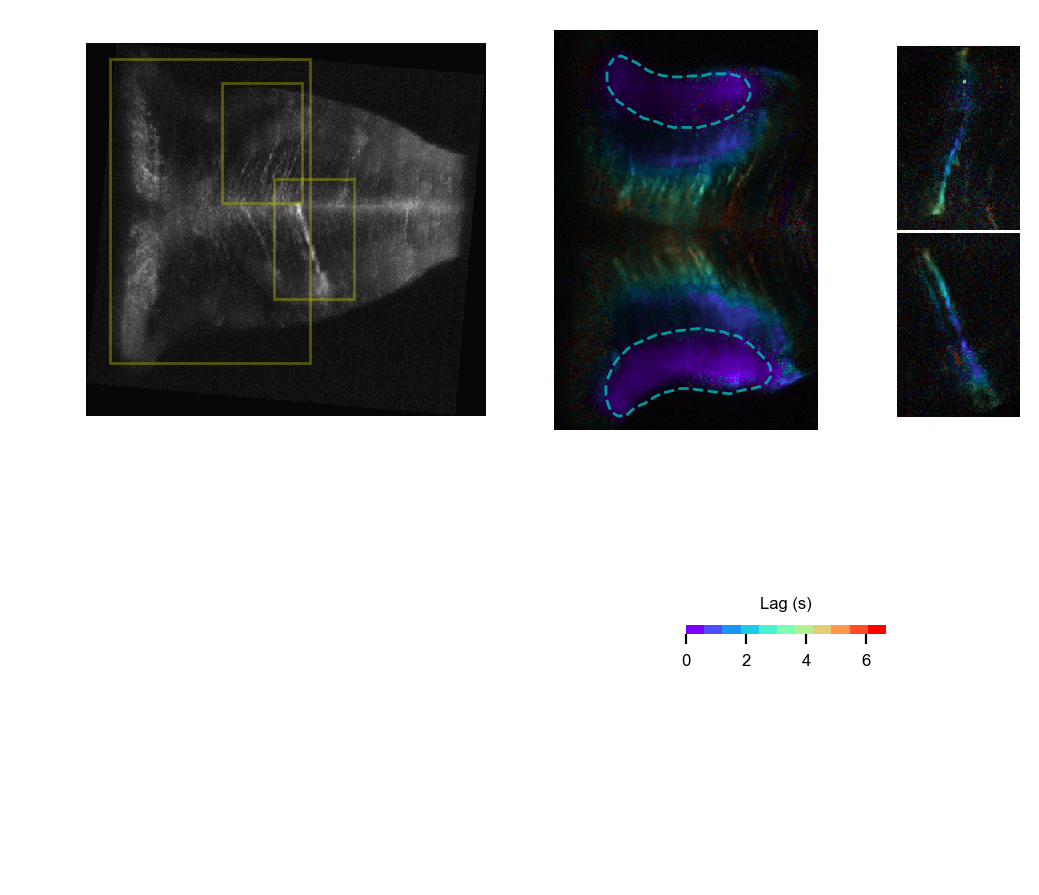

In [10]:
fig = plt.figure(dpi=200, figsize=(4,4))
axs_full = fig.add_axes((0,0,1,1))
axs_full.axis('off')
axs_anat = fig.add_axes((0, .5,.5,.5))
axs_anat.imshow(trave[:5].mean(0).max(0), cmap='gray')
axs_anat.axis('off')
axs_big_im = fig.add_axes((.5, .5, .5, .5))
axs_big_im.axis('off')
rects = []
for plr in (plr_stim, *plr_examples):
    rects.append(Rect((plr[2].start, plr[1].start), plr[2].stop - plr[2].start, plr[1].stop-plr[1].start, fill=False, edgecolor='y', alpha=.4)) 

bb_big_im = list(axs_big_im.get_position().bounds)
bb_cmap = bb_big_im.copy()
bb_cmap[2] *= .5
bb_cmap[3] *= .5
bb_cmap[0] += bb_big_im[2] * .5
bb_cmap[1] += bb_big_im[3] * -.75

axs_cmap = fig.add_axes(bb_cmap)

axs_example_1 = fig.add_axes((bb_big_im[0] + .49, bb_big_im[1] + .25, .2,.23))
axs_example_1.axis('off')
axs_example_1.imshow(phase_examples[0] * mag_examples[0])

axs_example_2 = fig.add_axes((bb_big_im[0] + .49, bb_big_im[1] + .0154,.2,.23))
axs_example_2.axis('off')
axs_example_2.imshow(phase_examples[1] * mag_examples[1])

cmap = np.arange(dur).reshape(-1,1) / fs_im
axs_cmap.imshow(cmap.T, cmap='rainbow', origin='lower', extent=(0,cmap[-1], 0,.3))
[sp.set_visible(False) for sp in axs_cmap.spines.values()]
axs_cmap.set_yticks([])
axs_cmap.tick_params(axis='x', colors='k', labelsize=6)

axs_cmap.title.set_fontsize(6)
axs_cmap.title.set_color('k')
axs_cmap.title.set_text('Lag (s)')
axs_big_im.imshow((phase_rgb * mag_rgb))
[axs_anat.add_patch(r) for r in rects]
[axs_big_im.plot(np.array(r[0][::10]) - plr_stim[2].start, np.array(r[1][::10]) - plr_stim[1].start,'c--', linewidth=1, alpha=.8) for r in roi_boundaries]
plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/gfap_stim_phase.pdf')

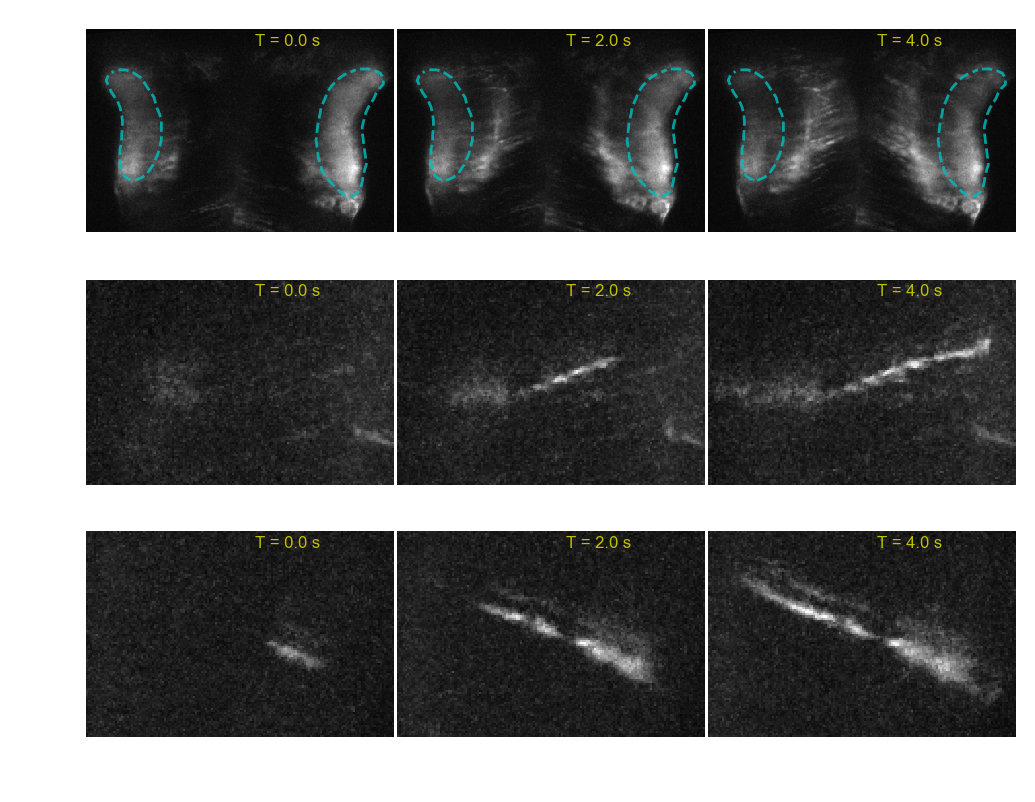

In [11]:
ds_t = 3
fig, axs = plt.subplots(nrows=3, ncols=(dur//ds_t), dpi=200, figsize=(6,5))

[axs[0][ind].imshow(trave.max(1)[plr_stim][::ds_t][ind].T, cmap='gray', clim=(0,1)) for ind in range(dur//ds_t)]
[ax.text(.55,.92, s=f'T = {(ind * ds_t)/fs_im} s', color='y', transform=ax.transAxes, fontsize=6) for row in axs for ind, ax in enumerate(row)]
#axs[0][-1].imshow(phase_rgb * mag_rgb)

[axs[1][ind].imshow(full[plr_examples[0]][::ds_t][ind].T, cmap='gray', clim=(0,1)) for ind in range(dur//ds_t)]
#axs[1][-1].imshow(phase_examples[0] * mag_examples[0])
[ax.plot(np.array(r[1][::10]) - plr_stim[1].start,np.array(r[0][::10]) - plr_stim[2].start, 'c--', linewidth=1, alpha=.8) for r in roi_boundaries for ax in axs[0]]

[axs[2][ind].imshow(full[plr_examples[1]][::ds_t][ind].T, cmap='gray', clim=(0,1)) for ind in range(dur//ds_t)]
#axs[2][-1].imshow(phase_examples[1] * mag_examples[1])
[ax.axis('off') for ax in axs.ravel()];
plt.subplots_adjust(wspace=.01,hspace=0)
plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/gfap_stim_snapshots.pdf')

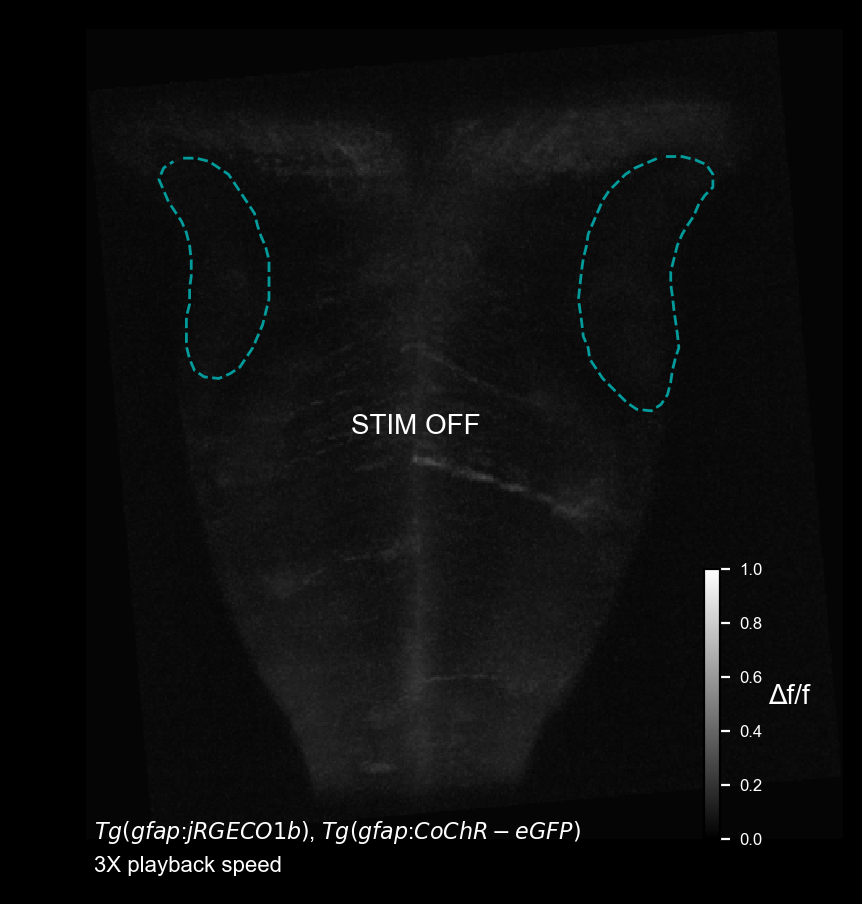

In [12]:
from scipy.interpolate import interp1d

plr = slice(None)
to_show = trave.max(1)[plr]
fps = 24
data_dur = 8

figsize = (8, 4.5)
fig, axs = plt.subplots(dpi=200, figsize=figsize, facecolor='k')
axs_cbar = fig.add_axes((.7,.1,.01,.3))
axs_cbar.tick_params(axis='both', colors='w', labelsize=6)
axs_cbar.text(4, .5, '\u0394f/f', transform=axs_cbar.transAxes, fontdict={'fontsize' : 10, 'color' : 'w'})
axs.set_facecolor('k')
axs.axis('off')
axs.set_position([.1,.1,.9,.9])

fd_small = {'fontsize' : 8, 'color' : 'w'}
speedup = int((to_show.shape[0] / fs_im) / data_dur)
rgeco_label = dict(x = .01, y=0, s='$\it{Tg(gfap}$:$\it{jRGECO1b})$, $\it{Tg(gfap}$:$\it{CoChR}-\it{eGFP})$', transform=axs.transAxes, fontdict=dict(color=(1,1,1), size=8))
timing_label = dict(x = .01, y=-.04, s=f'{speedup}X playback speed',transform=axs.transAxes, fontdict=dict(color='w', size=8))
axs.text(**rgeco_label)
axs.text(**timing_label)

interper = interp1d(x=np.linspace(0, data_dur, to_show.shape[0]),y=to_show, fill_value='extrapolate', axis=0)
t = 0
axs.imshow(interper(t).T, cmap='gray', clim=(0,1))
plt.colorbar(mappable=axs.images[0], cax=axs_cbar)
[axs.plot(np.array(r[1][::10]), np.array(r[0][::10]), 'c--', linewidth=1, alpha=.8) for r in roi_boundaries]

stim_text = axs.text(.35, .5, 'STIM OFF', transform=axs.transAxes, color='w')

def draw_frame(t):
    axs.texts[-1].set_text('STIM OFF')
    axs.texts[-1].set_color('w')
    if t >= (stim_epoch[0]/fs_im) / speedup and t<= (stim_epoch[-1]/fs_im) / speedup:
            axs.texts[-1].set_text('STIM ON')
            axs.texts[-1].set_color('c')
    axs.images[0].set_data(interper(t).T)
    return mplfig_to_npimage(fig)

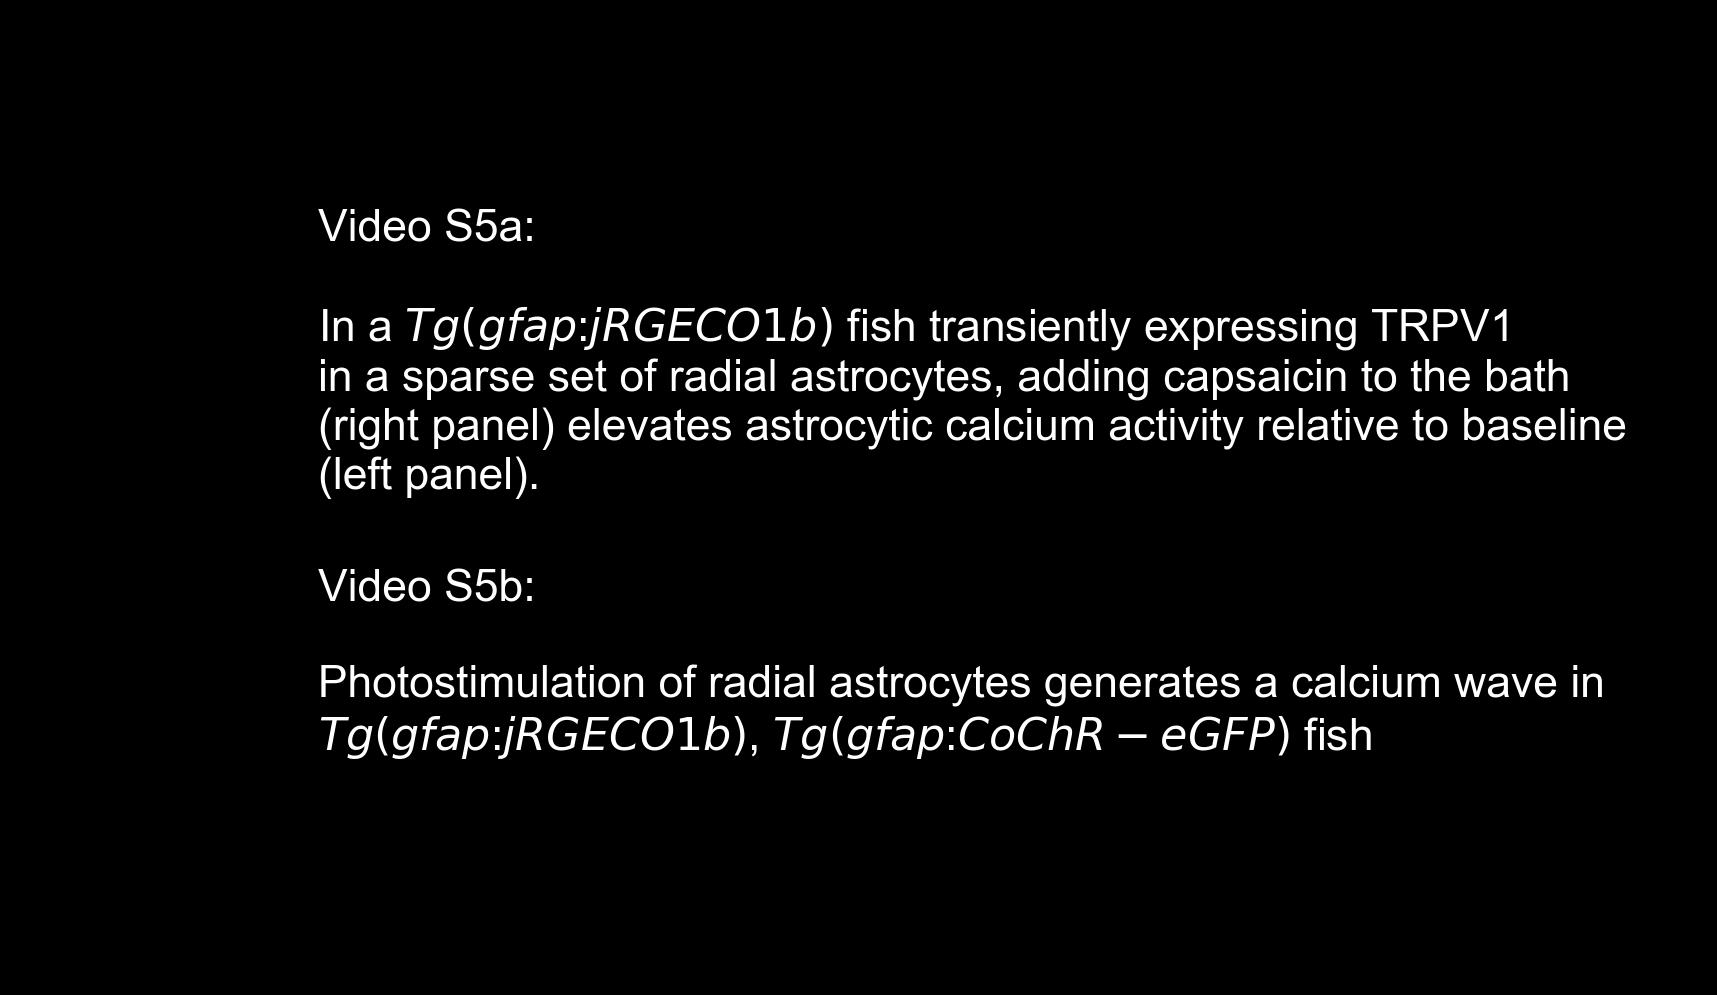

In [13]:
## make the title card 
title_dur = 4
fig_intro = plt.figure(dpi=200, figsize=figsize, facecolor='k')
ax_intro = fig_intro.add_axes((0,0,1,1))
ax_intro.set_facecolor('k')
s5a_intro_text ='''Video S5a:
                                
In a $\it{Tg(gfap}$:$\it{jRGECO1b)}$ fish transiently expressing TRPV1 
in a sparse set of radial astrocytes, adding capsaicin to the bath
(right panel) elevates astrocytic calcium activity relative to baseline 
(left panel).            
'''

s5b_intro_text = '''Video S5b:

Photostimulation of radial astrocytes generates a calcium wave in
$\it{Tg(gfap}$:$\it{jRGECO1b)}$, $\it{Tg(gfap}$:$\it{CoChR-eGFP)}$ fish                       
'''

color_fade = interp1d([0,1,2,3], [1,.75,.5,.5], fill_value='extrapolate')

s5a_intro = ax_intro.text(.15,
              .8,
              s5a_intro_text, 
              fontdict=dict(color='w', size=16), 
              transform=ax_intro.transAxes, 
              ha = 'left',
              va='top',
              multialignment='left')

s5b_intro = ax_intro.text(.15,
              .4,
              s5b_intro_text, 
              fontdict=dict(color='w', size=16), 
              transform=ax_intro.transAxes, 
              ha = 'left',
              va='top',
              multialignment='left')

def drawf_intro(t_):
    s5a_intro.set_color(3 * [0 + color_fade(t_)])
    return mplfig_to_npimage(fig_intro)

title_clip = VideoClip(drawf_intro, duration=title_dur)

In [14]:
data_clip = VideoClip(draw_frame, duration=data_dur)

codec = 'h264'
vid_fname = f'/groups/ahrens/ahrenslab/projects/ngm/presentation/movies/Video_S5b.mp4'

composite_clip = concatenate_videoclips([title_clip, data_clip])
composite_clip.write_videofile(vid_fname, audio=False, codec=codec, fps=fps, ffmpeg_params=['-pix_fmt', 'yuv420p'])

t:   1%|          | 2/288 [00:00<00:21, 13.54it/s, now=None]

Moviepy - Building video /groups/ahrens/ahrenslab/projects/ngm/presentation/movies/Video_S5b.mp4.
Moviepy - Writing video /groups/ahrens/ahrenslab/projects/ngm/presentation/movies/Video_S5b.mp4



Moviepy - Done !
Moviepy - video ready /groups/ahrens/ahrenslab/projects/ngm/presentation/movies/Video_S5b.mp4
